In [480]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

else:
    %cd /home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
from bnn_models import *
from train_utils import *
from data_utils import *
from hpo_util import *
from exp_utils import *
plt.style.use('ggplot')
%load_ext autoreload

/home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [481]:
if SERVER:
    data_dir = "/home/abdu/bio_ai/moses-incons-pen-xp/data"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [482]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [502]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [503]:
X_selected = X[driver_sym_list]
X_selected.shape

(406, 768)

In [504]:
from scipy.sparse import csgraph
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
L = csgraph.laplacian(J, normed=True)
J_zeros = np.zeros_like(J)

In [629]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler
seed = 745
# idxs = jax.random.choice(jax.random.PRNGKey(seed), jnp.arange(X_selected.shape[0]), (X_selected.shape[0] // 2, ), replace=False)
# X_selected_perm = X_selected.iloc[idxs]
# target_perm = target.iloc[idxs]
# print(X_selected_perm.shape)
transformer = QuantileTransformer(random_state=seed, output_distribution="normal")
X_train_outer, X_train, X_val, X_test, \
y_train_outer, y_train, y_val, y_test, (train_idxs, val_idxs) = preprocess_data(seed, X_selected, target,
                                                           transformer, val_size=0.2, test_size=0.2)

/home/abdu/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning:

n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.



In [634]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study_bnn = optuna.create_study(sampler=sampler)

study_bnn.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, J_zeros, 0.25, [100], "swish", bg=False), timeout=120)

[I 2023-02-18 10:14:25,944] A new study created in memory with name: no-name-9b7c8f0d-5a5b-48e9-80d2-b399ce306f9b
[I 2023-02-18 10:14:44,804] Trial 0 finished with value: 0.4659244120121002 and parameters: {'disc_lr_0': 0.1, 'num_cycles': 30, 'temp': 1.0, 'batch_size': 16, 'sigma': 1.0, 'mu': 2.806709715074587}. Best is trial 0 with value: 0.4659244120121002.
[I 2023-02-18 10:14:50,662] Trial 1 finished with value: 0.6394447684288025 and parameters: {'disc_lr_0': 0.1, 'num_cycles': 30, 'temp': 0.01, 'batch_size': 64, 'sigma': 0.5, 'mu': 77.07747663364894}. Best is trial 0 with value: 0.4659244120121002.
[I 2023-02-18 10:15:00,183] Trial 2 finished with value: 0.49518856406211853 and parameters: {'disc_lr_0': 0.5, 'num_cycles': 10, 'temp': 0.001, 'batch_size': 32, 'sigma': 0.5, 'mu': 15.535922474763439}. Best is trial 0 with value: 0.4659244120121002.
[I 2023-02-18 10:15:05,647] Trial 3 finished with value: 0.5737537145614624 and parameters: {'disc_lr_0': 0.5, 'num_cycles': 30, 'temp': 

In [635]:
from optuna.visualization import plot_param_importances
bnn_config = study_bnn.best_params
print(bnn_config)
plot_param_importances(study_bnn)

{'disc_lr_0': 0.1, 'num_cycles': 30, 'temp': 1.0, 'batch_size': 16, 'sigma': 1.0, 'mu': 2.806709715074587}


In [680]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study_bg = optuna.create_study(sampler=sampler)

study_bg.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, J, 0.25, [100, 100, 100], "swish", bg=True), timeout=120)

[I 2023-02-18 10:28:09,551] A new study created in memory with name: no-name-214107f0-3060-4196-890a-914a7a9ef1e0
[I 2023-02-18 10:28:34,240] Trial 0 finished with value: 0.48051005601882935 and parameters: {'disc_lr_0': 0.1, 'num_cycles': 20, 'temp': 0.001, 'batch_size': 16, 'sigma': 1.0, 'eta': 52.67562736765473, 'mu': 58.61329522172229}. Best is trial 0 with value: 0.48051005601882935.
[I 2023-02-18 10:28:58,463] Trial 1 finished with value: 0.5241856575012207 and parameters: {'disc_lr_0': 0.5, 'num_cycles': 50, 'temp': 1.0, 'batch_size': 16, 'sigma': 0.1, 'eta': -15.284808056855411, 'mu': 33.567006430679726}. Best is trial 0 with value: 0.48051005601882935.
[I 2023-02-18 10:29:22,435] Trial 2 finished with value: 0.7390639185905457 and parameters: {'disc_lr_0': 0.5, 'num_cycles': 20, 'temp': 0.1, 'batch_size': 16, 'sigma': 0.1, 'eta': 32.03937223414039, 'mu': 98.65796895812205}. Best is trial 0 with value: 0.48051005601882935.
[I 2023-02-18 10:29:29,980] Trial 3 finished with value

In [681]:
from optuna.visualization import plot_param_importances
bg_config = study_bg.best_params
print(bg_config)
plot_param_importances(study_bg)

{'disc_lr_0': 0.1, 'num_cycles': 20, 'temp': 0.001, 'batch_size': 16, 'sigma': 1.0, 'eta': 52.67562736765473, 'mu': 58.61329522172229}


In [605]:
import pickle
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc/tamox"
VERSION = "10b"
bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb"))
bnn_bg_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_{seed}_optuna_v{VERSION}.pkl", "rb"))
print(f"BNN config: {bnn_config}")
print(f"BG BNN config: {bnn_bg_config}")

BNN config: {'mu': 33.9170500819158}
BG BNN config: {'eta': 58.36007778863549, 'eta_sign': 1, 'mu': 41.208531570369864}


In [648]:
%autoreload
lr_0, disc_lr_0 = 1e-3, bnn_config["disc_lr_0"]
temp, sigma = bnn_config["temp"], bnn_config["sigma"]
epochs, num_cycles = 500, bnn_config["num_cycles"]
eta, mu = 1.0, bnn_config["mu"]
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=bnn_config["batch_size"], shuffle=True, drop_last=True)
bnn_model, bnn_states, bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                            0.25, 1, lr_0, disc_lr_0, [100], temp, sigma,
                                                            eta, mu, J_zeros, "swish")

bnn_rmse_train, bnn_r2_train = score_bg_bnn_model(bnn_model, X_train_outer, y_train_outer, bnn_states, bnn_disc_states, True)
bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bnn_model, X_test, y_test, bnn_states, bnn_disc_states, True)
print(f"Train RMSE: {bnn_rmse_train}, r2_score: {bnn_r2_train}")
print(f"Test RMSE: {bnn_rmse_test}, r2_score: {bnn_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.66it/s]


Train RMSE: 0.21628426015377045, r2_score: 0.8403121328638876
Test RMSE: 0.5783125162124634, r2_score: 0.07829120095671382


In [682]:
%autoreload
lr_0, disc_lr_0 = 1e-3, bg_config["disc_lr_0"]
temp, sigma = bg_config["temp"], bg_config["sigma"]
epochs, num_cycles = 500, bg_config["num_cycles"]
eta, mu = bg_config["eta"], bg_config["mu"]
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=bg_config["batch_size"], shuffle=True, drop_last=True)
bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader,epochs, num_cycles,
                                                                     0.25, 1, lr_0, disc_lr_0, [100, 100, 100], temp, sigma,
                                                                     eta, mu, J, "swish")

print(len(bg_bnn_states))
bnn_bg_rmse_train, bnn_bg_r2_train = score_bg_bnn_model(bg_bnn_model, X_train_outer, y_train_outer, bg_bnn_states, bg_bnn_disc_states, True)
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states, bg_bnn_disc_states, True)
print(f"Train RMSE: {bnn_bg_r2_train}, r2_score: {bnn_bg_r2_train}")
print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.40it/s]


20
Train RMSE: 0.9465048975948702, r2_score: 0.9465048975948702
Test RMSE: 0.6468507647514343, r2_score: -0.1531260331664015


In [683]:
np.mean(tfp.mcmc.effective_sample_size(np.array(bg_bnn_disc_states)))

Array(nan, dtype=float32)

(array([279.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 489.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

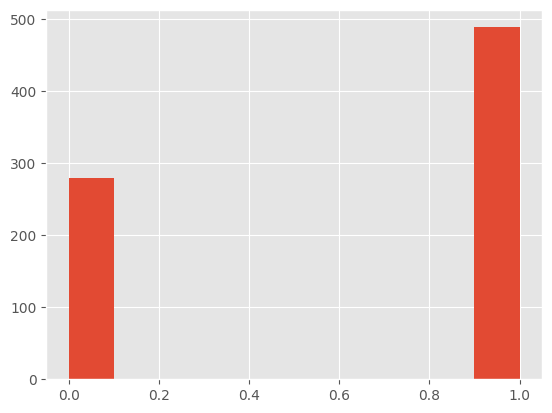

In [684]:
plt.hist(np.mean(np.array(bg_bnn_disc_states), axis=0))

In [677]:
np.argsort(np.mean(np.array(bg_bnn_disc_states), axis=0))[::-1]

array([489, 680, 482, 343,  87, 220, 734, 300, 441, 322, 611, 318, 600,
       152, 161, 314, 587, 176, 310, 178, 447, 617, 129, 433, 132,  79,
       678, 670,  91, 419, 660, 105, 333, 643, 638, 118, 120, 634, 481,
       575, 180, 571, 572,  75, 467, 232, 470, 515, 241, 472, 511, 246,
       508, 248, 504, 253, 497, 477, 479, 284, 526, 286, 195, 568, 566,
       187, 189, 191, 194, 198, 288, 211, 213, 460, 217, 218, 531,  77,
       383, 736, 699,   9, 357,   8,  59, 708,  19,  20,  60, 362,  44,
       724,  36, 375, 385,  68, 742, 706, 741,   1, 717,  50, 690, 387,
       737, 556, 409, 391, 200, 201, 204, 205, 544, 543, 549,  29, 301,
       309, 349, 172, 175, 360, 361, 580, 577, 448,  32, 368, 569, 729,
       567, 730, 367, 458, 190, 562, 370,  21, 540, 756, 384, 279, 505,
       251, 501, 255, 498,   3, 258, 276, 492, 265, 764, 488, 266, 269,
       484, 247, 755, 371, 281, 372, 461, 313, 293, 226, 747, 748,  17,
       386, 522, 283, 469, 236, 237, 239, 753,  11, 720, 324,  4

In [678]:
X_selected.iloc[:,np.argsort(np.mean(np.array(bg_bnn_disc_states), axis=0))[::-1][:10]]

,PCDH17,TCL1A,PAX3,KIT,CBFA2T3,FAM186A,WNK2,HOXD11,NFIB,IRF1
0,0.142679,0.000000,5.703500,1.145866,0.000000,0.000000,2.548722,0.096670,4.343456,2.386104
1,0.000000,0.000000,1.191607,1.676464,0.455970,0.000000,0.773673,4.713812,3.047038,3.437397
2,0.000000,0.081046,0.000000,0.000000,0.081046,0.000000,2.867602,0.000000,4.617486,3.965274
3,0.000000,0.000000,0.695845,0.625134,0.054834,0.000000,0.795810,2.621141,4.292413,3.701468
4,0.930639,0.000000,0.000000,1.259442,2.439902,0.000000,3.050294,0.097208,0.702492,4.674401
...,...,...,...,...,...,...,...,...,...,...
401,0.000000,0.000000,0.000000,7.195149,5.374307,0.050252,0.000000,0.050252,0.050252,3.617265
402,3.601899,0.000000,5.227092,4.041402,0.000000,0.000000,3.236843,5.724907,4.220613,1.682305
403,0.000000,10.082403,0.000000,0.000000,4.125676,0.051817,5.678354,0.000000,0.196957,5.263435
404,0.736563,0.000000,0.115400,2.447639,1.480481,0.000000,2.333094,0.840858,4.036144,2.680975


In [69]:
rf_model = train_rf_model(seed, X_train_outer, y_train_outer, train_idxs, val_idxs)
eval_rf_model(rf_model, X_test, y_test)

(Array(1.0073216, dtype=float32), 0.2729924841841177)

### BMM

In [204]:
seeds, data_dfs, net_dfs, feat_ls = load_bmm_files(f"{data_dir}/bmm_data_thr_5_F_8_f500")

In [328]:
seed = seeds[-1]
X, y = data_dfs[-1].iloc[:,:-1], data_dfs[-1].iloc[:,-1]
X_train_outer, X_train, X_val, X_test, y_train_outer, \
    y_train, y_val, y_test, (train_indices, val_indices) = preprocess_data(seed, X, y, reset_index=True)

In [409]:
%autoreload
# rf_model = train_rf_model(seed, X_train_outer, y_train_outer,
#                           train_indices, val_indices, classifier=True)
eval_rf_model(rf_model, X_test, y_test, classifier=True)

(0.7018666666666665, 0.75)

In [437]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler)

study.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, J_zeros, 0.99, [100], "swish", bg=False,
                                                 classifier=True), timeout=300)

[I 2023-02-15 10:18:33,480] A new study created in memory with name: no-name-c7e48510-c938-42ab-8dbc-82f524d0c8cb
[I 2023-02-15 10:19:25,370] Trial 0 finished with value: 0.5949656750572082 and parameters: {'lr_0': 0.01, 'disc_lr_0': 0.1, 'num_cycles': 20, 'temp': 0.001, 'batch_size': 16, 'sigma': 0.1, 'mu': 51.52200866433364}. Best is trial 0 with value: 0.5949656750572082.
[I 2023-02-15 10:20:00,055] Trial 1 finished with value: 0.5949656750572082 and parameters: {'lr_0': 0.1, 'disc_lr_0': 0.1, 'num_cycles': 20, 'temp': 0.01, 'batch_size': 16, 'sigma': 0.01, 'mu': 37.16330503134095}. Best is trial 0 with value: 0.5949656750572082.
[I 2023-02-15 10:20:34,766] Trial 2 finished with value: 0.5949656750572082 and parameters: {'lr_0': 0.005, 'disc_lr_0': 0.1, 'num_cycles': 20, 'temp': 0.01, 'batch_size': 16, 'sigma': 0.1, 'mu': 58.759012415376304}. Best is trial 0 with value: 0.5949656750572082.
[I 2023-02-15 10:21:06,170] Trial 3 finished with value: 0.5804729214340199 and parameters: {'

In [453]:
bnn_config = study.best_params
bnn_config

{'lr_0': 0.001,
 'disc_lr_0': 0.1,
 'num_cycles': 30,
 'temp': 1.0,
 'batch_size': 16,
 'sigma': 0.1,
 'mu': 93.03889995357929}

In [455]:
%autoreload
optuna.logging.set_verbosity(optuna.logging.INFO)
sampler = optuna.samplers.TPESampler()
study_bg = optuna.create_study(sampler=sampler)

study_bg.optimize(lambda trial: objective_bg_bnn(trial, seed, X_train, X_val, y_train, y_val, J, 0.25, [100], "swish", bg=True,
                                                 classifier=True), timeout=300)

[I 2023-02-15 10:41:37,470] A new study created in memory with name: no-name-d139faff-9af0-4bb7-ad49-e251b462888d
[I 2023-02-15 10:42:01,024] Trial 0 finished with value: 0.5949656750572082 and parameters: {'lr_0': 0.01, 'disc_lr_0': 0.1, 'num_cycles': 40, 'temp': 0.1, 'batch_size': 16, 'sigma': 0.5, 'eta': 35.04825383779141, 'mu': 25.056935028093534}. Best is trial 0 with value: 0.5949656750572082.
[I 2023-02-15 10:42:13,191] Trial 1 finished with value: 0.5949656750572082 and parameters: {'lr_0': 0.005, 'disc_lr_0': 0.5, 'num_cycles': 50, 'temp': 0.001, 'batch_size': 32, 'sigma': 0.5, 'eta': -34.00603566379479, 'mu': 58.306669284481295}. Best is trial 0 with value: 0.5949656750572082.
[I 2023-02-15 10:42:34,422] Trial 2 finished with value: 0.32875667429443167 and parameters: {'lr_0': 0.001, 'disc_lr_0': 0.1, 'num_cycles': 30, 'temp': 0.1, 'batch_size': 16, 'sigma': 0.1, 'eta': -75.59681975310085, 'mu': 89.93764566107346}. Best is trial 2 with value: 0.32875667429443167.
[I 2023-02-1

In [456]:
bg_config = study_bg.best_params
bg_config

{'lr_0': 0.001,
 'disc_lr_0': 0.8,
 'num_cycles': 50,
 'temp': 0.1,
 'batch_size': 16,
 'sigma': 0.5,
 'eta': -79.60034580387256,
 'mu': 37.855893510582106}

In [466]:
%autoreload
lr_0, disc_lr_0 = bnn_config["lr_0"], bnn_config["disc_lr_0"]
temp, sigma = bnn_config["temp"], bnn_config["sigma"]
epochs, num_cycles = 500, bnn_config["num_cycles"]
eta, mu = 1., bnn_config["mu"]
J = net_dfs[-1].values
J_zeros = np.zeros_like(J)
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=bnn_config["batch_size"], shuffle=True,
                                drop_last=True)
bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                                     0.99, 1, lr_0, disc_lr_0, [100], temp, sigma,
                                                                     eta, mu, J_zeros, "swish", classifier=True, show_pgbar=True)

print(len(bg_bnn_states))
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states[-1], bg_bnn_disc_states[-1], True, True)
print(f"Test auc: {bnn_bg_rmse_test}, accuracy: {bnn_bg_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.47it/s]

31
Test auc: 0.6997333333333333, accuracy: 0.75


In [479]:
%autoreload
lr_0, disc_lr_0 = bg_config["lr_0"], bg_config["disc_lr_0"]
temp, sigma = bg_config["temp"], 1.0
epochs, num_cycles = 500, bg_config["num_cycles"]
eta, mu = bg_config["eta"], bg_config["mu"]
J = net_dfs[-1].values
outer_data_loader = NumpyLoader(NumpyData(X_train_outer, y_train_outer), batch_size=bg_config["batch_size"],
                                shuffle=True, drop_last=True)
bg_bnn_model, bg_bnn_states, bg_bnn_disc_states = train_bg_bnn_model(seed, outer_data_loader, epochs, num_cycles,
                                                                                 0.25, 2, lr_0, disc_lr_0, [10], temp, sigma,
                                                                                 eta, mu, J, "swish", classifier=True, show_pgbar=True)

print(len(bg_bnn_states))
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bg_bnn_states, bg_bnn_disc_states, True, True)
print(f"Test auc: {bnn_bg_rmse_test}, accuracy: {bnn_bg_r2_test}")

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.04it/s]


100
Test auc: 0.5264, accuracy: 0.25


In [478]:
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_train_outer, y_train_outer, bg_bnn_states, bg_bnn_disc_states, True, True)
print(f"Train auc: {bnn_bg_rmse_test}, accuracy: {bnn_bg_r2_test}")

Train auc: 0.8620821226262803, accuracy: 0.7775


In [461]:
tfp.mcmc.effective_sample_size(np.array(bg_bnn_disc_states))

Array([100.      , 100.      , 100.      ,        nan, 100.      ,
       100.      , 100.      , 100.000015,        nan, 100.      ,
       100.      ,        nan, 100.      ,        nan, 100.      ,
       100.      ,        nan, 100.      ,        nan, 100.      ,
              nan, 100.      ,        nan, 100.000015, 100.      ,
              nan,        nan,        nan, 100.      , 100.      ,
       100.      , 100.      ,        nan, 100.      , 100.      ,
       100.      , 100.      ,        nan,        nan,        nan,
              nan, 100.      , 100.      ,        nan, 100.      ,
        50.52588 , 100.      , 100.      , 100.      , 100.      ,
              nan,        nan, 100.      , 100.      , 100.      ,
       100.      , 100.000015, 100.      ,        nan, 100.      ,
       100.      , 100.      , 100.      ,        nan, 100.      ,
              nan,        nan, 100.      ,        nan,        nan,
       100.      ,        nan, 100.      ,        nan, 100.   

In [451]:
params_bnn_bg = tree_utils.tree_stack(bg_bnn_states)
gammas_bnn_bg = tree_utils.tree_stack(bg_bnn_disc_states)

In [394]:
igs_bg_bnn = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bg_bnn_model, params_bnn_bg, gammas_bnn_bg, X_val, 20)

In [452]:
%autoreload
get_feats_dropout_loss(bg_bnn_model, params_bnn_bg, gammas_bnn_bg, X_val, y_val, classifier=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


,feats_idx,num_models,loss_on,loss_off,loss_diff
430,430,40,1154.8109,1779.837,-625.0261
341,341,40,1165.7172,1438.8077,-273.09058
266,266,40,1143.4028,1281.9012,-138.49841
293,293,41,1194.8547,1282.5645,-87.70972
455,455,40,1169.856,1250.6329,-80.77698
...,...,...,...,...,...
290,290,0,0.0,0.0,1000000000.0
299,299,0,0.0,0.0,1000000000.0
308,308,0,0.0,0.0,1000000000.0
250,250,0,0.0,0.0,1000000000.0


In [388]:
feat_ls[-1]

[342, 282, 13, 431, 257, 141, 8, 294]

In [396]:
J[8]

array([ 0.       ,  0.       ,  0.       ,  0.       , -0.38045  ,
       -0.24348  ,  0.       , -0.59819  ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  1.4049   ,
       -0.92565  ,  0.       ,  0.31593  ,  0.       , -0.83773  ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.2197   ,  0.       ,  0.       ,  0.       ,  1.4264   ,
        0.       , -0.68542  , -1.4066   ,  0.       ,  0.       ,
        0.       , -0.14608  ,  0.       ,  0.       , -1.2284   ,
        1.5293   ,  0.       ,  0.027992 ,  0.18515  ,  0.       ,
        0.       ,  1.7999   ,  0.       ,  0.       ,  0.33441  ,
        0.       ,  0.       ,  0.       ,  0.4929   , -1.1687   ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
       -1.3438   ,  0.88032  ,  0.       ,  0.       ,  0.       ,
       -1.3041   ,  0.       , -0.12924  ,  0.       ,  0.56425  ,
        0.       ,  0.       ,  0.       ,  0.1161   ,  0.    